In [14]:
import torch
import io
import os
from math import log
import torch
from torch import tensor
import json
from botorch.models import SingleTaskGP, FixedNoiseGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective import ExpectedHypervolumeImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
import asyncio
dtype = torch.float64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def x_to_filename(x):
    return f'{x[0]}_{x[1]}_{x[2]}_{x[3]}.json'

def filename_to_x(filename):
    return [float(x) for x in filename[:-5].split('_')]

NUM_CORES=14
running_tasks={}
async def wait_for_core_to_be_available():
    while len(running_tasks)>NUM_CORES:
        await asyncio.sleep(1.0)

async def evaluate_profile(x):
    await wait_for_core_to_be_available()
    filename=x_to_filename(x)
    running_tasks[filename]=True
    #display(filename)
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    #display(distances)
    if len(distances)==0 or min(distances)>0.001:
        config=json.dumps({
            'p':x[0],
            'm':x[1],
            't':x[2],
            'a':x[3]
        })
        p=await asyncio.create_subprocess_shell(f'cd case; ./evaluate_airfoil.sh \'{config}\'',stdout=asyncio.subprocess.PIPE)
        await p.wait()
        #os.system(f'cd case; ./evaluate_airfoil.sh \'{config}\'')
    existing_result_files=os.listdir("case/results")
    existing_results_x=[filename_to_x(filename) for filename in existing_result_files]
    distances=[torch.dist(torch.tensor(x),torch.tensor(existing_x)).item() for existing_x in existing_results_x]
    min_distance_index=distances.index(min(distances))
    with open("case/results/"+existing_result_files[min_distance_index]) as file:
        result=json.load(file)
        #display(result)
        running_tasks.pop(filename)
        return [result['C_L'],-log(max(result['C_D'],1e-3))]



In [15]:

train_Y=tensor([[ 2.5682, -0.1000],
        [ 2.0647, -0.2619],
        [ 0.8586, -0.3635],
        [-0.1484, -0.5712],
        [ 0.1847, -0.2351],
        [ 2.6430, -0.0745],
        [ 2.0525, -0.1163],
        [ 0.6526, -0.3782],
        [ 0.2102, -0.7816],
        [-0.3878, -0.7461],
        [ 1.5345, -0.2404],
        [ 1.9892, -0.1187],
        [-0.3236, -0.1533],
        [ 0.4294, -0.3404],
        [ 0.4834, -0.2573],
        [ 2.3373, -0.0715],
        [ 0.6749, -0.2269],
        [-0.9758, -0.3770],
        [ 0.5953, -0.1955],
        [ 1.0729, -0.1619],
        [ 1.9164, -0.1899],
        [ 2.5516, -0.0683],
        [-0.2328, -0.3449],
        [ 2.0594, -0.0828],
        [ 0.8026, -0.2346],
        [ 1.9782, -0.2079],
        [ 1.7411, -0.2242],
        [-0.6203, -0.4925],
        [-0.0880, -0.4709],
        [ 1.0294, -0.5481],
        [-0.8890, -0.1470],
        [ 1.4512, -0.3181],
        [ 0.4131, -0.6159],
        [-0.1686, -0.5047],
        [ 0.6094, -0.1095],
        [ 2.4007, -0.2412],
        [ 0.8611, -0.3514],
        [ 1.0458, -0.3757],
        [ 1.5283, -0.2352],
        [ 0.8043, -0.6279],
        [ 2.5720, -0.0803],
        [ 2.5579, -0.1087],
        [ 2.7006, -0.0298],
        [ 2.7038, -0.0175],
        [ 2.5011, -0.0595],
        [ 2.5347, -0.1359],
        [ 2.6557, -0.0455],
        [ 2.6776, -0.0620],
        [ 2.4428, -0.0861],
        [ 2.7103, -0.0326]], dtype=torch.float64)
train_Y_log=tensor([[ 0.1674,  0.2564],
        [ 0.7936,  1.4822],
        [ 0.3221,  0.2812],
        [ 1.9782,  1.5708],
        [ 2.5682,  2.3028],
        [-0.0068, -0.0076],
        [ 2.5632,  2.7421],
        [ 1.8880,  1.8210],
        [ 1.1445,  2.1617],
        [ 0.2357,  1.5106],
        [-0.1413,  1.6523],
        [ 0.1847,  1.4477],
        [-0.4437,  0.2331],
        [-0.0587,  1.3783],
        [ 2.3373,  2.6377],
        [-0.6203,  0.7083],
        [-0.9963,  0.9493],
        [ 1.9164,  1.6613],
        [ 0.9866,  2.1796],
        [ 1.0294,  0.6014],
        [ 1.9108,  1.8137],
        [ 2.1724,  1.9516],
        [ 0.4294,  1.0776],
        [ 1.6101,  1.3918],
        [ 0.6749,  1.4832],
        [ 0.0243,  0.3156],
        [ 0.5701,  0.3651],
        [ 0.0447,  0.1697],
        [ 2.4744,  2.7713],
        [ 2.3167,  2.9390],
        [ 0.6315,  0.6008],
        [ 1.0458,  0.9788],
        [ 1.0729,  1.8208],
        [ 2.5529,  3.1740],
        [-0.3141,  0.9254],
        [ 0.6094,  2.2121],
        [-0.9758,  0.9755],
        [ 1.4512,  1.1454],
        [ 1.4377,  1.6688],
        [ 1.8186,  1.2679],
        [ 1.9892,  2.1312],
        [ 1.7804,  1.8980],
        [ 0.5953,  1.6324],
        [-0.0823, -0.0697],
        [ 1.8232,  1.5105],
        [ 1.9870,  1.6254],
        [ 0.2102,  0.2464],
        [ 0.7149,  0.5244],
        [ 2.0117,  1.5005],
        [-0.1437,  0.0167],
        [ 2.4642,  2.8047],
        [ 2.4348,  1.9983],
        [ 2.5593,  2.9972],
        [ 2.6102,  2.5698],
        [ 2.4577,  2.1441],
        [ 2.5135,  2.4941],
        [ 2.4884,  3.5005],
        [ 2.5272,  2.1940],
        [ 2.7007,  3.0705],
        [ 2.5183,  3.6546],
        [2.66843, 4.141624866803403],
        [2.67203, 3.762569052259808],
        [2.7295, 3.9538455002819846]], dtype=torch.float64)

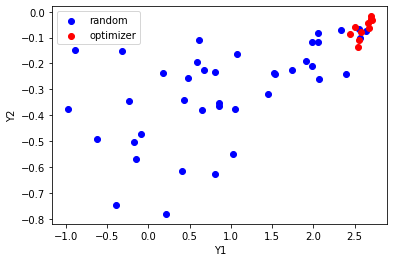

In [16]:
import plotting
plotting.plot_population(train_Y,10)

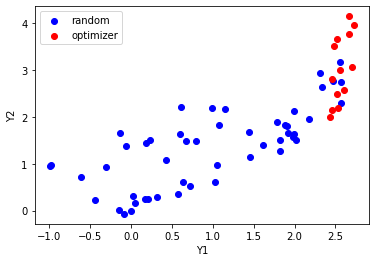

In [17]:

plotting.plot_population(train_Y_log,13)